# 今さら聞けないGANシリーズ(4)
https://qiita.com/triwave33/items/5c95db572b0e4d0df4f0  
Wasserstein GANについて  

https://arxiv.org/pdf/1701.07875.pdf  
WGANの原論文  
論文発表に使ったり，参考文献にしたり  

https://www.alexirpan.com/2017/02/22/wasserstein-gan.html  
⬆︎の素晴らしい概要
  
http://musyoku.github.io/2017/02/06/Wasserstein-GAN/  
WGANの簡単な理論と実装について，アニメ画像生成で実験  
  
http://yusuke-ujitoko.hatenablog.com/entry/2017/05/20/145924  
WGANの⬆︎よりは詳しい理論といらすとや画像生成による実験  
  
https://qiita.com/mittyantest/items/0fdc9ce7624dbd2ee134  
WGANとKantorovich-Rubinstein双対性  
Wasserstein距離についての数学的な説明，むじゅい

Wasserstein距離で損失関数を設計したWGANのコンセプトを学ぶ  
さらにGradient penaltyを導入したWGAN-gpを導入する

## まとめ
- GANはGeneratorのパラメータの最適値付近で勾配消失し学習が進まなくなる
    - 損失関数のbinary cross entropy関数がJSDを使っていることになるため
- JSDの代わりにWasserstein距離を損失関数に使う**WGAN**を提唱
    - 結果，損失関数にはlogを用いない
    - D(x)の結果にsigmoidをかける必要がなくなった
- WGANではD(x)がリプシッツな関数である必要がある
- リプシッツな関数にするためにパラメータのclipをしていたが，不安定
- clipの代わりに勾配ペナルティを損失関数に加えた**WGAN-gp**を提唱
    - 生成データと実データの間の点では勾配のL2ノルムが1になる
    - そのL2ノルムが1にならない時ペナルティを与え，リプシッツにする
    - 実装では，BCEを使う代わりにf-imgとr-imgから得るWGANのlossとそれらの間のa-imgから得るgradient penaltyからなる損失関数を最適化する

## 損失関数
通常のGANの損失関数  
$$ min_G max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)} [ \log{D(x)} ] + \mathbb{E}_{z \sim p_z(z)} [ \log{(1 - D(G(z))} ] $$

Discriminatorを最適化する時は，本物データを本物と識別し，偽物データを偽物と識別するのが良い．  
これは二値分類問題なので，binary cross entropy関数を損失関数として用いていた．  
  
本物データの確率密度分布$p_{data}(x)$と生成データの確率密度分布$p_g(z)$が固定されている場合(Dはこれら2つを持っており，それを学習する?)，最適な識別関数$D^*$は以下になる．($x=G(z)$または本物データ)  
$$ D^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}$$

直感的には，何らかの画像データを入力した時に本物データの分布に近い出力を得た時1(正解)，そうでないとき，つまり偽物データの分布に近い出力を得た時0(不正解)を出力する関数

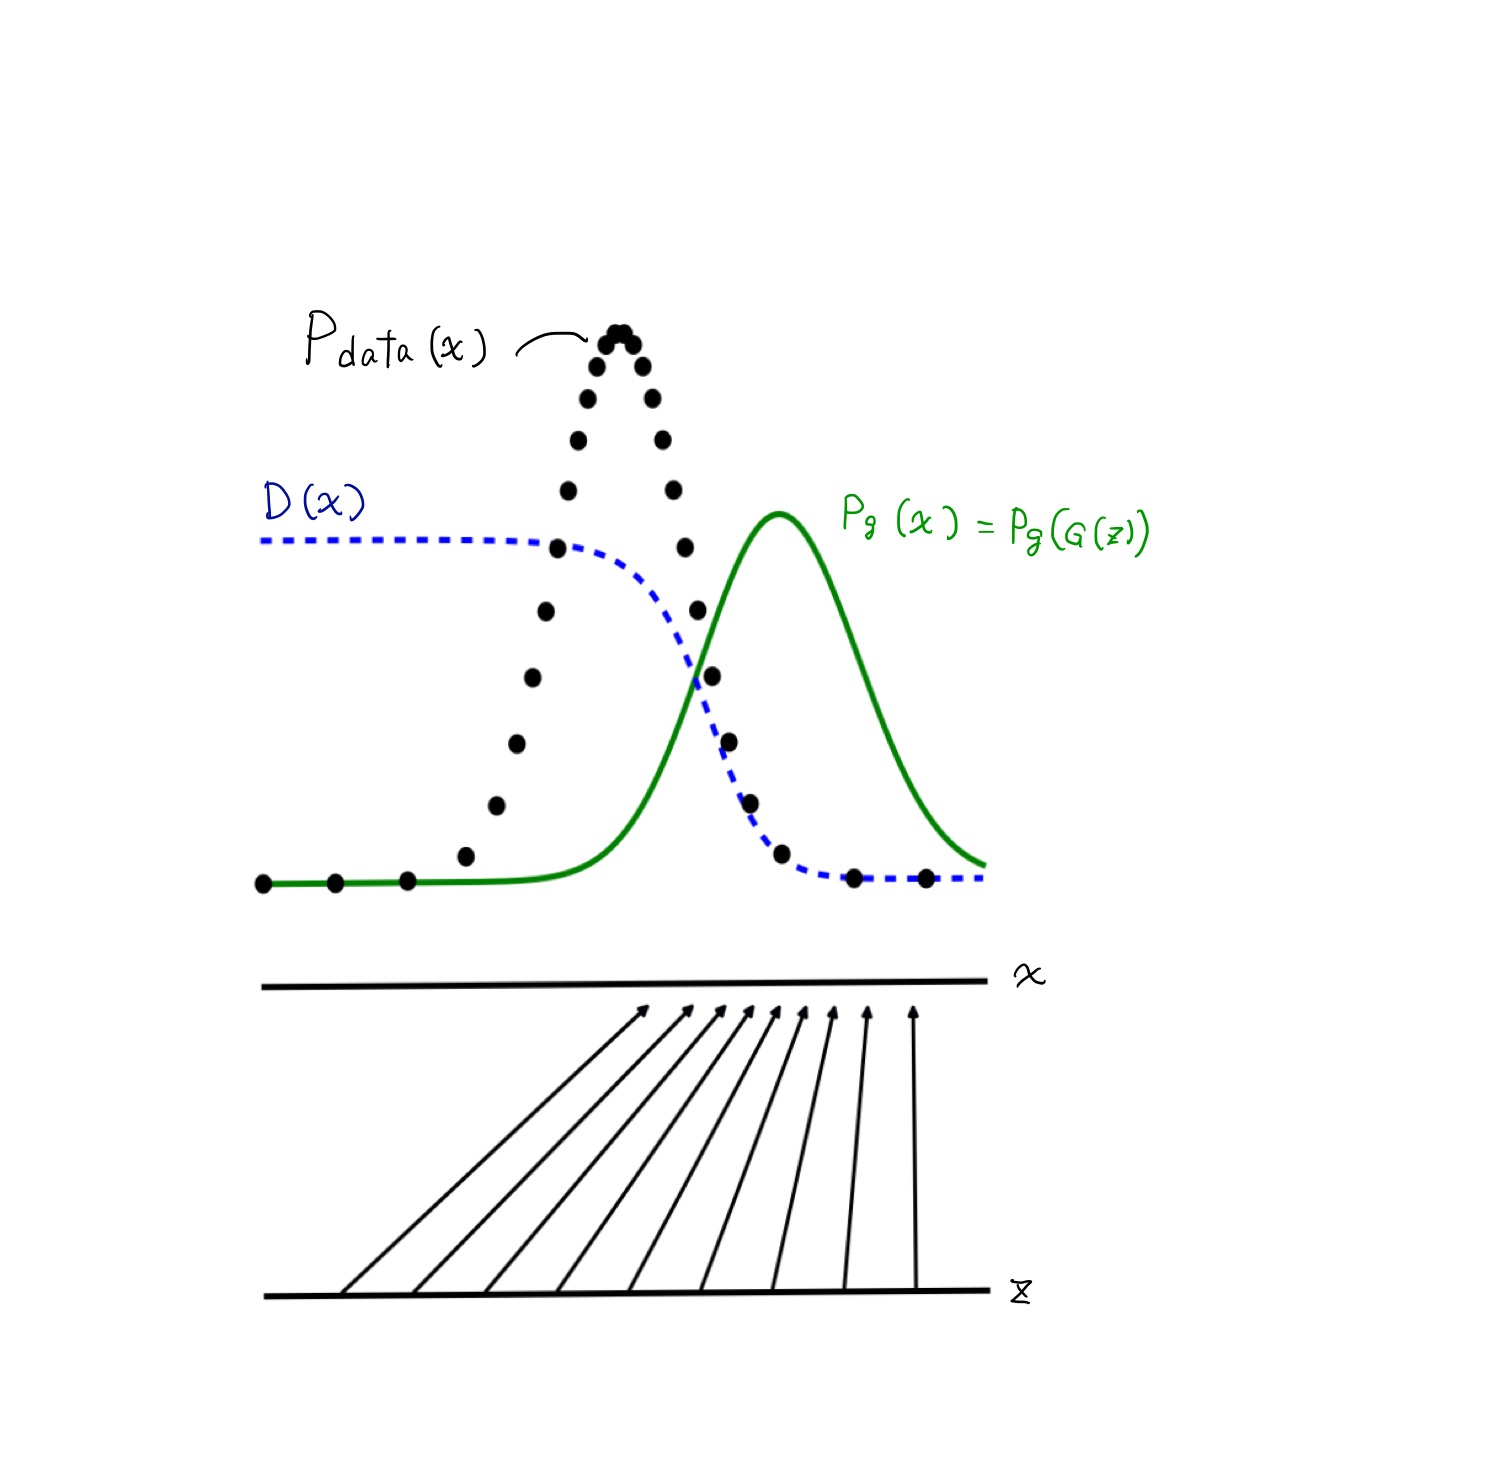  
本物データの分布$p_{data}(x)$のピーク付近(サンプリングされやすいとこ)では識別関数$D^*$は1に近づき，生成データの分布$p_g(x)$のピーク付近では$D^*$が0に近づく．その交点では識別関数は0.5付近の値になる．  
そして，$G$によって$z$は生成データ$x$へと変換がなされる．

## Jensen-Shannon ダイバージェンス  
最適なDiscriminator下でのGeneratorの価値関数は次のようになる  
  
$$ C(G) = -log(4) + 2 \times JSD(p_{data} || p_g) $$ 
  
JSDはJensen-Shannon ダイバージェンスで2つの確率密度間の距離を示す．  
$p_{data}(x)$と$p_z(x)$が全ての$x$で完全に一致する時，JSDは0になる．  
  
言い換えると，通常のGANはJSDを指標に，2つの確率密度間の距離を近づけていく作業  
  
しかしこれによって，勾配消失問題が発生してしまう．  
Generatorのパラメータ$\theta$の最適値周りで勾配が0になってしまい，学習がうまく行かなくなることが知られている．(WGANの原論文より)  
 

そこで，JSDの代わりにWasserstein距離を使うというコンセプトに基づくのがWGAN  
WGANはパラメータの最適点付近で勾配が消失せず，学習が安定して進む  
結果だけ書くと，Wasserstein距離Wは以下のように表される  
  
$$ W(\mathbb{P}_r, \mathbb{P}_\theta) = max_{w \in W} \mathbb{E}_{x \sim \mathbb{P}_r} [f_W (x)] - \mathbb{E}_{z \sim p(z)}[f_W(g_{\theta}(z))] $$
  
ここで，$\mathbb{P}_r$はreal dataの分布を意味しているのだと思われる．  
kerasでは損失関数の最小化を行うので，この式にマイナスをかけて最小化問題に定式化する．結果，最小化するべき損失関数$L$は
  
$$ L = \mathbb{E}_{\tilde{x} \sim \mathbb{P}_g} [D(\tilde{x})] - \mathbb{E}_{x \sim \mathbb{P}_r}  [D(x)] $$
  
$\tilde{x}$はzより生成した画像，$x$は本物の画像を示す．  
  
WGANの特徴は，**損失関数にlogを用いていない**ことである．  
さらに$D(x)$は識別結果としての意味を持たず，W距離計算のためのパーツになったため，出力をsigmoid関数で[0, 1]に押し込める必要もない．  
そのため，WGANでは$D(x)$のことを$f(x)$と表したり，Discriminatorの代わりにCriticと呼んだりする．  

## Discriminatorの制約条件
$D(x)$がWasserstein距離として意味を持つには，$D(x)$がリプシッツな関数である必要がある．  
詳しいことは置いておくが，この制約条件を満たすために，初期のWGANでは重みパラメータの最小，最大値をclipしているが，これが不安定になる要因になっている．  
そこで，clipの代わりに損失関数にペナルティ項を与えることで学習の最適化を達成する，WGAN-gpというものが提案された．  
  
最適化されたDiscriminatorでは，生成データと本物データ間の任意の点$\hat{x}$での勾配のL2ノルムが1になるという性質があることが知られている．  
この性質を逆手にとって，損失関数に勾配のL2ノルムが1以外の時にペナルティを課す  

$$ L_{WGANgp} = L_{WGAN} + \lambda \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}} [ (||\nabla_{\hat{x}} D(\hat{x})||_2 - 1)^2 ] $$
ここで$\hat{x}$は生成データと本物データを結んだ直線上の任意の点  
  
これでリプシッツな関数になるということ？  
つまり，生成データと本物データの外側に行かないように学習する？

## WGAN-gpのDiscriminatorの構造
通常のGANではGeneratorとDiscriminatorを完全に切り離していた．  
また，本物データと生成データは別々に学習させる  
  
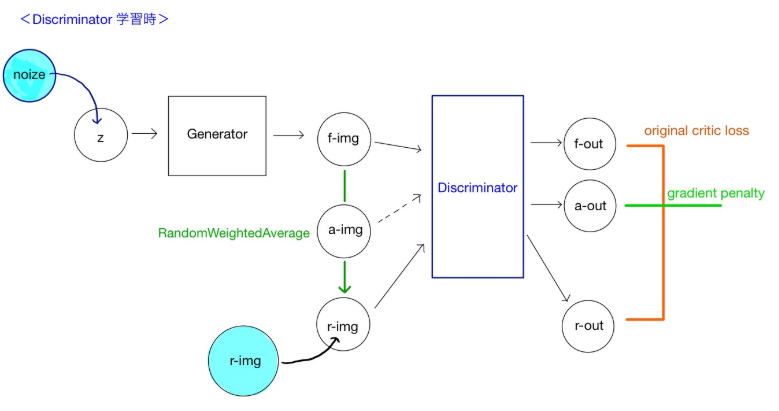
  
WGAN-gpのDiscriminatorは  
- 本物データと生成データを同時に学習させる  
- WGAN-gpの入力はnoizeとr-imgを用いる
- Discriminatorに対する実質的な入力は
    - f-img (fake)
    - r-img (real)
    - **a-img (average, 各入力を直線で繋いだ間の任意の点)**
        - a-imgの生成のため，RandomWeightedAverageを実装
- これらの画像をDに与え，f-out,r-out,a-outを得て損失関数の値とする
    - f-outとr-outから得るOriginal crigtic loss
    - a-outから得るgradient penalty
- 最終的にOptimizerを定義することによってDiscriminatorの学習を進める

GANを試す場合は，うまく行かないのがアルゴリズムのせいか，実装のせいか，パラメータのせいか，どれが原因かわかりにくいのが問題